# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, sum, split, stddev, udf, when, lag, isnull
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import Window

import datetime

import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#set seaborn style
sns.set(style="whitegrid")

# Set spark environments
os.environ['PYSPARK_PYTHON'] = '/Users/stillqe/anaconda/envs/Sparkify/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Users/stillqe/anaconda/envs/Sparkify/bin/python3'

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sample = 'mini_sparkify_event_data.json'
df = spark.read.json(sample)
df.printSchema()
print('Shape of Dataset: ' ,(df.count(), len(df.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Shape of Dataset:  (286500, 18)


The dataset used here for EDA and model selection is a small subset of the original dataset of 128 GB. The sample dataset consists of 286500 rows and 18 columns. Let's first check for missing or invalid data and clean it.

In [4]:
def count_missings(spark_df):
    spark_df.select([count(when(isnull(c), c)).alias(c) for c in spark_df.columns]).show()

count_missings(df)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There are 8346 records that don't have any user related information such as userId, firstName, lastName, etc. Other records with missing values on song-related information are normal records generated by events such as setting up or visiting the homepage, not playing songs.

In [5]:
df = df.where(df.userId != "")
count_missings(df)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# Exploratory Data Analysis

We can find out what events users have done through the page feature. As it is a music streaming service, the most frequent event is music playback, followed by upvoting, visiting the homepage, and adding a playlist, etc.

(0.0, 50000.0)

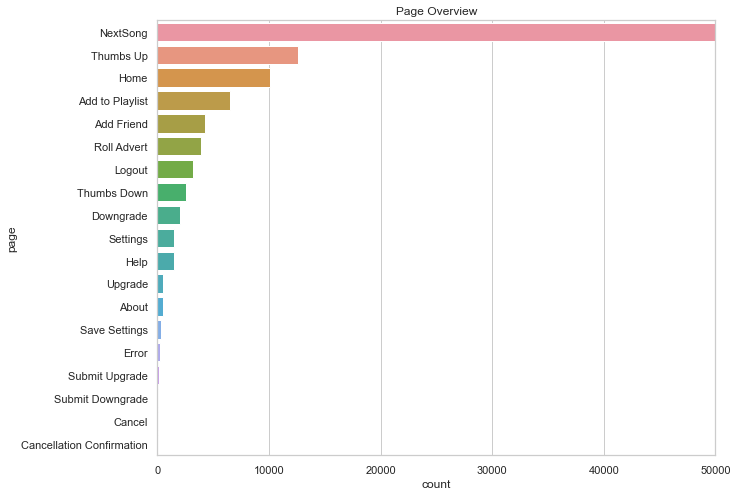

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
ax.set(title="Page Overview")
sns.barplot(y='page', x='count',data=df.groupBy('page').count().orderBy(col('count').desc()).toPandas())
ax.set_xlim(0,50000)

We can also check the distribution of paid and free users by gender and browser.

<AxesSubplot:xlabel='level', ylabel='count(userId)'>

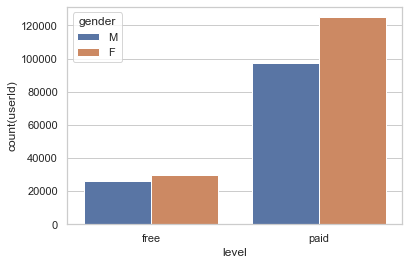

In [8]:
sns.barplot(x='level',y='count(userId)',hue='gender', data=df.groupBy('level','gender').agg({'userId':'count'}).toPandas())

In [9]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN
    
browser = udf(lambda x: get_browser(x))
df = df.withColumn('browser', browser(df.userAgent))

<AxesSubplot:xlabel='browser', ylabel='count(userId)'>

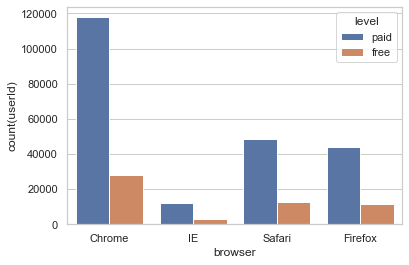

In [10]:
sns.barplot(x='browser',y='count(userId)',hue='level', data=df.groupBy('browser','level').agg({'userId':'count'}).toPandas())

# Feature Engineering


## Preprocess data

- The user who has visited the cancellation confirmation page is defined as churned user.
- The categorical page feature is transformed into multiple features by one-hot-encoding.

In [11]:
df = df.withColumn('cancel', when(df.page == 'Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('thumpsup', when(df.page == 'Thumbs Up', 1).otherwise(0)) \
    .withColumn('thumpsdown', when(df.page == 'Thumbs Down', 1).otherwise(0)) \
    .withColumn('ad', when(df.page == 'Roll Advert', 1).otherwise(0)) \
    .withColumn('playlist', when(df.page == 'Add to Playlist', 1).otherwise(0)) \
    .withColumn('friend', when(df.page == 'Add Friend', 1).otherwise(0)) \
    .withColumn('error', when(df.page == 'Error', 1).otherwise(0)) \
    .withColumn('home', when(df.page == 'Home', 1).otherwise(0)) \
    .withColumn('downgrade', when(df.page == 'Downgrade', 1).otherwise(0)) \
    .withColumn('upgrade', when(df.page == 'Upgrade', 1).otherwise(0)) \
    .withColumn('setting', when(df.page == 'Save Settings', 1).otherwise(0)) \
    .withColumn('ts', col('ts')/1000) \
    .withColumn('registration', col('registration')/1000) \
    .withColumn('day', ((col('ts')-col('registration'))/(60*60*24)).cast(IntegerType()))

- The time stamped raw data will be grouped by user id and session id.

In [12]:


sessions = df.groupBy('userId', 'sessionId').agg(count('song').alias('play'),
                                                 max('cancel').alias('churn'),
                                                 min('day').alias('day'),
                                                 min('ts').alias('start'),
                                                 max('ts').alias('end'),                                                 
                                                 max('level').alias('level'),
                                                 max('gender').alias('gender'),
                                                 max('browser').alias('browser'),
                                                 sum('thumpsup').alias('thumpsup'),
                                                 sum('thumpsdown').alias('thumpsdown'),
                                                 sum('ad').alias('ads'),
                                                 sum('playlist').alias('playlists'),
                                                 sum('friend').alias('friends'),
                                                 sum('error').alias('errors'),
                                                 sum('setting').alias('setting')) \
    .withColumn('duration', (col('end') - col('start')).cast(IntegerType()))


windowSpec = Window.partitionBy('userId').orderBy('start')
userWindow = Window.partitionBy('userId')

#how many days passed between sessions
sessions = sessions.withColumn('gap', col('day') - lag('day', 1, 0).over(windowSpec))
sessions = sessions.withColumn('churn', max('churn').over(userWindow))
sessions = sessions.withColumn('last', max('day').over(userWindow))

- The grouped data will be aggreated for each user. Finally we will get one aggregated row for each user.

In [13]:
users = sessions.groupBy('userId').agg(count('sessionId').alias('total_session'),
                                       avg('play').alias('avg_play'),
                                       when(count('play') > 1, stddev('play')).otherwise(0).alias('std_play'),
                                       avg('thumpsup').alias('avg_up'),
                                       avg('thumpsdown').alias('avg_down'),
                                       avg('ads').alias('avg_ads'),
                                       avg('setting').alias('avg_setting'),
                                       avg('playlists').alias('avg_playlists'),
                                       avg('friends').alias('avg_friends'),
                                       avg('duration').alias('avg_duration'),
                                       when(count('duration') > 1, stddev('duration')).otherwise(0).alias('std_duration'), 
                                       avg('gap').alias('avg_gap'),
                                       when(count('gap') > 1, stddev('gap')).otherwise(0).alias('std_gap'),
                                       max('day').alias('life_time'),
                                       max('churn').alias('label'))

recent = sessions.where(sessions.day>(sessions.last-14)).groupBy('userId') \
                                  .agg(when(count('sessionId')>0, avg('play')).otherwise(0).alias('recent_play'),
                                       when(count('play') > 1, stddev('play')).otherwise(0).alias('recent_std_play'),
                                       when(count('sessionId')>0,avg('thumpsup')).otherwise(0).alias('recent_up'),
                                       when(count('sessionId')>0,avg('thumpsdown')).otherwise(0).alias('recent_down'),
                                       when(count('sessionId')>0,avg('ads')).otherwise(0).alias('recent_ads'),
                                       when(count('sessionId')>0,avg('setting')).otherwise(0).alias('recent_setting'),
                                       when(count('sessionId')>0,avg('playlists')).otherwise(0).alias('recent_playlists'),
                                       when(count('sessionId')>0,avg('friends')).otherwise(0).alias('recent_friends'),
                                       when(count('sessionId')>0,avg('duration')).otherwise(0).alias('recent_duration'),
                                       when(count('sessionId')>0,avg('gap')).otherwise(0).alias('recent_gap'),
                                       when(count('gap') > 1, stddev('gap')).otherwise(0).alias('recent_std_gap'))




users = users.join(recent, on='userId')                                                             

- Visualize how some extracted features are distributed according to the label.

[Text(0.5, 1.0, 'Average staying time per session'),
 Text(0.5, 0, 'churn'),
 Text(0, 0.5, '')]

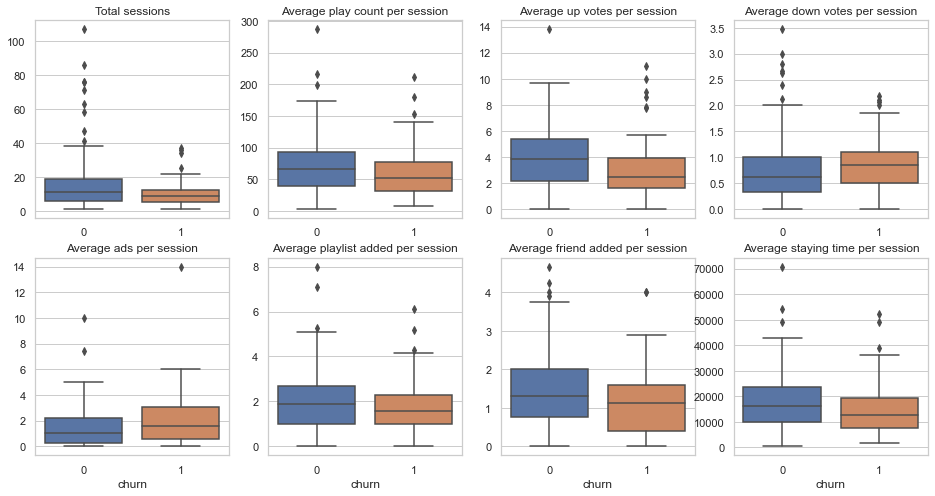

In [14]:
pd_users =users.select("total_session","avg_play","std_play","avg_up","avg_down","avg_ads","avg_playlists",
                       "avg_friends","avg_duration","std_duration","avg_gap","std_gap","label").toPandas()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

sns.boxplot(ax=axes[0,0], x="label", y="total_session", data=pd_users)
axes[0,0].set(title="Total sessions", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,1], x="label", y="avg_play", data=pd_users)
axes[0,1].set(title="Average play count per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,2], x="label", y="avg_up", data=pd_users)
axes[0,2].set(title="Average up votes per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,3], x="label", y="avg_down", data=pd_users)
axes[0,3].set(title="Average down votes per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[1,0], x="label", y="avg_ads", data=pd_users)
axes[1,0].set(title="Average ads per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[1,1], x="label", y="avg_playlists", data=pd_users)
axes[1,1].set(title="Average playlist added per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[1,2], x="label", y="avg_friends", data=pd_users)
axes[1,2].set(title="Average friend added per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[1,3], x="label", y="avg_duration", data=pd_users)
axes[1,3].set(title="Average staying time per session", xlabel='churn',ylabel='')

# Modeling
## baseline classifier
First, let's check four representative classifiers such as logistic regression, decision tree, random forest, and gradient boosting tree without tuning hyperparameters to get a baseline. Since the churned users are a fairly small subset, we are using F1 score as the metric to optimize.

In [22]:
SEED=123
# Split the data into train and test subsets
train, test = users.randomSplit([0.8, 0.2], seed=SEED)

assembler = VectorAssembler(inputCols=["total_session",
                                       "avg_play",
                                       "std_play",
                                       "avg_up",
                                       "avg_down",
                                       "avg_ads",
                                       "avg_setting",
                                       "avg_playlists",
                                       "avg_friends",
                                       "avg_duration",
                                       "std_duration",
                                       "avg_gap",
                                       "std_gap",
                                       "life_time",
                                       "recent_play",
                                       "recent_std_play",
                                       "recent_up",
                                       "recent_down",
                                       "recent_ads",
                                       "recent_setting",
                                       "recent_playlists",
                                       "recent_friends",
                                       "recent_duration",
                                       "recent_gap",
                                       "recent_std_gap"
                                      ], outputCol="NumFeatures")

scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)

In [23]:
def check_baseline():
    lr = LogisticRegression()
    dt = DecisionTreeClassifier(seed=SEED)
    rf = RandomForestClassifier(featuresCol="features")
    gbt = GBTClassifier(featuresCol="features", maxIter=10)
    
    for clf in [lr, dt, rf, gbt]:
        clf_name = clf.__class__.__name__
        pipeline = Pipeline(stages=[assembler, scaler, clf])
        model = pipeline.fit(train)
        pred_test = model.transform(test)
        f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
        f1_score = f1_score_evaluator.evaluate(pred_test.select('label','prediction'),{f1_score_evaluator.metricName: 'f1'})

        print('{} : The F1 score on the test set is {:.2%}'.format(clf_name, f1_score))
        
check_baseline()

LogisticRegression : The F1 score on the test set is 77.55%
DecisionTreeClassifier : The F1 score on the test set is 76.18%
RandomForestClassifier : The F1 score on the test set is 78.61%
GBTClassifier : The F1 score on the test set is 74.23%


## Fine tune the selected model

As we can see above, the random forest model works best. Now we tune hyperparameters for random forest model. We are using a cross-validation method to avoid overfitting and get more general results.

In [24]:
clf = RandomForestClassifier(featuresCol="features")
pipeline = Pipeline(stages=[assembler, scaler, clf])

paramGrid = ParamGridBuilder() \
            .addGrid(clf.maxDepth, [3, 5, 10]) \
            .addGrid(clf.numTrees, [10, 20, 40]) \
            .addGrid(clf.maxBins, [16, 32, 64]).build()

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

[0.7664790025336337,
 0.7768797842244426,
 0.7791263924496259,
 0.7653635265175116,
 0.7321736798379506,
 0.7567855097008562,
 0.7442240275468095,
 0.7503141602122558,
 0.7658934997416208,
 0.7731383215441037,
 0.7992795122246799,
 0.7792985200766782,
 0.7852337978302779,
 0.7653887704050517,
 0.7787738040139622,
 0.7570821461613959,
 0.7607324936046085,
 0.758053182019409,
 0.770137664714234,
 0.7917038734899335,
 0.7786730281285372,
 0.7939473065437865,
 0.760867160407528,
 0.7561931610240753,
 0.7663965365852317,
 0.756320720996289,
 0.7853837832770132]

# Results and Limitations

In [26]:
pred_test = cvModel.transform(test)
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(pred_test.select('label','prediction'),{f1_score_evaluator.metricName: 'f1'})

print('The F1 score of the fine-tuned model on the test set is {:.2%}'.format(f1_score))

The F1 score of the fine-tuned model on the test set is 78.13%


In [27]:
inputCols=["total_session", "avg_play","std_play","avg_up","avg_down","avg_ads","avg_setting","avg_playlists",
           "avg_friends","avg_duration","std_duration","avg_gap","std_gap","life_time","recent_play",
                                       "recent_std_play",
                                       "recent_up",
                                       "recent_down",
                                       "recent_ads",
                                       "recent_setting",
                                       "recent_playlists",
                                       "recent_friends",
                                       "recent_duration",
                                       "recent_gap",
                                       "recent_std_gap"]
# print feature importances
for i in range(len(cvModel.bestModel.stages[-1].featureImportances)):
    print("{} : {} \n".format(inputCols[i], cvModel.bestModel.stages[-1].featureImportances[i]))


total_session : 0.016258040917460324 

avg_play : 0.035296206293131946 

std_play : 0.031184034413085326 

avg_up : 0.011100422820686106 

avg_down : 0.03119248768034103 

avg_ads : 0.06278029151927533 

avg_setting : 0.020150509718108407 

avg_playlists : 0.03104788437197961 

avg_friends : 0.03202030491301703 

avg_duration : 0.058859871489838324 

std_duration : 0.013479595407684609 

avg_gap : 0.023103751577902554 

std_gap : 0.011190623749428245 

life_time : 0.3121919550758399 

recent_play : 0.033415738445543394 

recent_std_play : 0.013509290906352325 

recent_up : 0.011344359289843103 

recent_down : 0.05141944057958062 

recent_ads : 0.0804797364795451 

recent_setting : 0.009198919224910299 

recent_playlists : 0.021379499894722605 

recent_friends : 0.0170894467333906 

recent_duration : 0.015808608767388634 

recent_gap : 0.042932553872191324 

recent_std_gap : 0.013566425858753315 



The F1 score of the best model is 88.62%, and it looks reasonable. I think there is room for improvement through ensembles with other models and more hyperparameters tuning. 

Also, it is practically not useful to predict churning with a whole records including right before churn. We need to predict churning in advance, for example, 30 days before the cancellation, to take proactive actions. For this reason, the data from 30 days before the last session could be excluded.

The last thing I want to mention is the importance of trend-related information. Because user interactions and attitudes toward the service change over time, we need to analyze what events occur in a particular time frame and how it changes over time. However, the analysis here seems to have limitations in this part. More specifically, in the process of aggregating the number of time series data into one record per user, the trend-related information would be missing.  Of course, the features of the last 14 days have been selected to prevent missing the information, but it might be insufficient. There is a possibility that we will get better performance if we include more trend-related features, or if we even use all the raw data without an aggregation process.